In [ ]:
!pip install torchsummary

In [86]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch
import torchvision

RESIZE=96
CROP_SIZE=(RESIZE,RESIZE)
transform = T.Compose([
    T.Resize(RESIZE),
    T.RandomCrop(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(0,1),
])

#download https://www.kaggle.com/datasets/prasunroy/natural-images
dataset = torchvision.datasets.ImageFolder(
    "/kaggle/input/natural-images/natural_images",
    transform=transform)

targets_names = {}
targets = []
for im in dataset.imgs:
    targets.append(im[1])
    targets_names[im[1]]=im[0].split("/")[-2]
# разделим датасет
train_idx, test_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.05,
    stratify=targets
)

# создадим даталодеры
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

cat


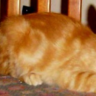

In [74]:
from random import randint
index = randint(0,len(dataset)-1)
sample = dataset[index]
print(targets_names[sample[1]])
T.ToPILImage()(sample[0])

In [ ]:
# Свёртка.
kernel_size=7
inc = 3
outc = 10
dilation=1
padding=(kernel_size+(kernel_size-1)*(dilation-1))//2

conv_layer = torch.nn.Conv2d(
    in_channels=inc,         # Число каналов на входе.
    out_channels=outc,       # Число каналов на выходе.
    kernel_size=kernel_size,         # Размер ядра.
    padding=padding,             # Размер паддинга (1 элемент добавляется с каждой стороны).
    padding_mode="zeros",  # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
    stride=3,              # Stride - 1 (смотрим на каждую позицию).
    dilation=dilation,            # Dilation - 1 (ядро прикладывается к фрагменту изображения без пропусков).
)

up_dim_conv = torch.nn.Conv2d(
    in_channels=inc,         # Число каналов на входе.
    out_channels=outc,       # Число каналов на выходе.
    kernel_size=1,         # Размер ядра.
    stride=1,              # Stride - 1 (смотрим на каждую позицию).
)

# Применяется слой свёртки к группе картинок в формате bs x c x h x w.
x = torch.rand(2, 3, 192, 192)

print(f"Размер до свёртки: {x.shape}")

out_v = conv_layer(x)

print(f"Размер после свёртки: {out_v.shape}")

x_up = up_dim_conv(x)

print(f"Размер после приведения размера: {x_up.shape}")

In [77]:
import torch
class ResidualBlock(torch.nn.Module):
    """This residual block allows to do basic residual convolution with custon dilations on each output layer"""
    def __init__(
        self,
        in_channels,                   # Number of input channels.
        out_channels,                  # Number of output channels.
        kernel_size,                   # Kernel size.
        stride,
        dilation,                     # List of dilation values for each output channel.
        activation=torch.nn.ReLU,      # Activation function.
        repeats = 1,                  # how many times repeat block internal transformation
        batch_norm = True, #add batch normalization
        x_downsample = None # how to downsample x
    ):
        super().__init__()

        if stride!=1 and x_downsample is None:
            x_downsample = torch.nn.MaxPool2d((stride,stride))
        
        if x_downsample is None: x_downsample = torch.nn.Identity()
        self.x_downsample=x_downsample
        
        if not isinstance(dilation,list):
            dilation=[dilation]*out_channels

        if not isinstance(kernel_size,list):
            kernel_size=[kernel_size]*out_channels
        assert len(dilation) == out_channels, "Number of dilations must match the number of output channels."

        self.activation = activation()

        # If input and output channel sizes differ, we need a projection layer.
        if in_channels != out_channels:
            self.correct_channels = torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Identity layer if sizes match.
        
        out_channels_ = [1]
        kernel_sizes_ = [kernel_size[0]]
        dilations_ = [dilation[0]]
        for c_size,c_dilation in list(zip(kernel_size,dilation))[1:]:
            if c_size==kernel_sizes_[-1] and c_dilation==dilations_[-1]:
                out_channels_[-1]+=1
            else:
                out_channels_.append(1)
                kernel_sizes_.append(c_size)
                dilations_.append(c_dilation)
        
        self.convs = []
        self.batch_norms = []
        for v in range(repeats):
            in_ch = in_channels if v==0 else out_channels
            stride_ = stride if v==0 else 1
            # Store the conv layers for each output channel with different dilations.
            
            conv = torch.nn.ModuleList([
                torch.nn.Conv2d(
                    in_channels=in_ch,
                    out_channels=out_channels_[i],          # Output one channel at a time.
                    kernel_size=kernel_sizes_[i],
                    padding=(kernel_sizes_[i] + (kernel_sizes_[i] - 1) * (dilations_[i] - 1)) // 2,
                    padding_mode="zeros",
                    dilation=dilations_[i],
                    stride=stride_
                )
                for i in range(len(out_channels_))
            ])
            
            self.convs.append(conv)
            batch_norm = \
                torch.nn.BatchNorm2d(out_channels) \
                if batch_norm else torch.nn.Identity()
            self.batch_norms.append(batch_norm)
        self.convs = torch.nn.ModuleList(self.convs)
        self.batch_norms = torch.nn.ModuleList(self.batch_norms)

    def forward(self, x):
        # Apply each convolution with different dilations to the input and concatenate.
        out_v = x
        for convs,norm in zip(self.convs,self.batch_norms):
            # Fork to parallelize each convolution operation
            futures = [torch.jit.fork(conv, out_v) for conv in convs]
            # Wait for all operations to complete and collect the results
            results = [torch.jit.wait(future) for future in futures]
            out_v = torch.cat(results, dim=1)
            out_v = norm(out_v)
            out_v = self.activation(out_v)
        
        x=self.x_downsample(x)
        x=self.correct_channels(x)
        out_v = out_v + x
        # always add x as it was putted-in (without activation applied)
        # so we can get best gradient information flow as linear operation
        return out_v

In [ ]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 10 каналов на выходе,
# размер ядра свертки равен 3 и
# в качестве функци активации используется ReLU
res_conv = ResidualBlock(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    stride=1,
    dilation=1,
    activation=torch.nn.ReLU)

x = torch.rand(2, 3, 192, 192)
res = res_conv(x)

print(x.shape)
print(res.shape)

In [ ]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 10 каналов на входе, 10 каналов на выходе и
# размер ядра свертки равен 3 и
# в качестве функции активации используется "Гиперболический тангенс"

res_conv = ResidualBlock(
    in_channels=10,
    out_channels=3,
    kernel_size=3,
    stride=1,
    dilation=1,
    activation=torch.nn.Tanh)

x = torch.rand(2, 10, 192, 192)
res = res_conv(x)

print(x.shape)
print(res.shape)

In [ ]:
# пример с различными значениями dilation и kernel_size на каждом из слоев, с повторами блока и downsample у блока
res_conv = ResidualBlock(
    in_channels=3,
    out_channels=4,
    kernel_size=[3,5,5,7],
    stride=3,
    dilation=[1,2,3,4],
    activation=torch.nn.ReLU,
    repeats=3,
    batch_norm=True
)

x = torch.rand(2, 3, 192, 192)
res = res_conv(x)

print(x.shape)
print(res.shape)
res_conv

In [ ]:
a = ResidualBlock(
    in_channels=3,
    out_channels=32,
    kernel_size=[3]*16+[5]*16,
    stride = 2,
    dilation=[1]*8+[2]*8+[1]*8+[2]*8,
    repeats=2,
    activation=torch.nn.ReLU,
    batch_norm=True)
a

In [ ]:
class ResidualNetwork(torch.nn.Module):
    def __init__(self,in_channels=3,classes = 100):
        super().__init__()
        self.block1 = ResidualBlock(
            in_channels=in_channels,
            out_channels=64,
            kernel_size= [3]*32        + [5]*16      + [7]*16,
            stride = 2,
            dilation=    [1]*16+[2]*16 + [1]*8+[2]*8 + [1]*8+[2]*8,
            repeats=2,
            activation=torch.nn.ReLU,
            batch_norm=True)
        self.block2 = ResidualBlock(
            in_channels=64,
            out_channels=128,
            kernel_size=[3]*64        + [5]*64,
            stride = 2,
            dilation=   [1]*32+[2]*32 + [1]*32+[2]*32,
            repeats=2,
            activation=torch.nn.ReLU,
            batch_norm=True)
        self.block3 = ResidualBlock(
            in_channels=128,
            out_channels=128,
            kernel_size=5,
            stride = 2,
            dilation=1,
            repeats=2,
            activation=torch.nn.ReLU,
            batch_norm=True)

        pool_size = 6
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(pool_size)
        self.fc = torch.nn.Linear(128*pool_size**2,classes)
    
    def forward(self,x):
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.block3(x)
        # print(x.shape)
        x = self.avg_pool(x)
        # print(x.shape)
        x=x.flatten(1)
        return self.fc(x)

In [78]:

# model(x).shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
            Conv2d-2           [-1, 16, 96, 96]             448
            Conv2d-3            [-1, 8, 96, 96]             608
            Conv2d-4            [-1, 8, 96, 96]             608
            Conv2d-5            [-1, 8, 96, 96]           1,184
            Conv2d-6            [-1, 8, 96, 96]           1,184
       BatchNorm2d-7           [-1, 64, 96, 96]             128
              ReLU-8           [-1, 64, 96, 96]               0
            Conv2d-9           [-1, 16, 96, 96]           9,232
           Conv2d-10           [-1, 16, 96, 96]           9,232
           Conv2d-11            [-1, 8, 96, 96]          12,808
           Conv2d-12            [-1, 8, 96, 96]          12,808
           Conv2d-13            [-1, 8, 96, 96]          25,096
           Conv2d-14            [-1, 8,

In [84]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.nn.parallel import DataParallel as DP
import torch.distributed as dist
import os
from torchsummary import summary
device='cuda'

model = ResidualNetwork()
model_dp = DP(model).to(device)

x = torch.rand(2, 3, 192, 192)
summary(model,x[0].shape)

In [92]:
import torch.nn.functional as F
from torch.optim import AdamW
from torchmetrics import Accuracy
from tqdm import tqdm


optim = AdamW(model.parameters(), lr=0.001)
metric = Accuracy(task="multiclass", num_classes=len(targets_names.keys())).to(device)
train_acc = []
test_acc = []

for epoch in range(20):
    avg_train_acc = 0
    avg_test_acc = 0
    avg_train_loss = 0
    avg_test_loss = 0

    # Training loop with tqdm progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Training", leave=False)
    computed_samples = 0
    for batch in train_loader_tqdm:
        computed_samples+=1
        images = batch[0].to(device)
        classes = batch[1].to(device)
        pred = model_dp(images)  # Use model_dp directly
        loss = F.cross_entropy(pred, classes)
        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_class = torch.argmax(pred, dim=1)
        avg_train_acc += metric(pred_class, classes).item()
        avg_train_loss += loss.item()

        train_loader_tqdm.set_postfix({"loss": avg_train_loss / computed_samples, 
                                       "acc": avg_train_acc / computed_samples})

    # Testing loop with tqdm progress bar
    test_loader_tqdm = tqdm(test_loader, desc=f"Testing", leave=False)
    
    computed_samples = 0
    for batch in test_loader_tqdm:
        computed_samples+=1
        images = batch[0].to(device)
        classes = batch[1].to(device)
        with torch.no_grad():
            pred = model(images)  # No need for model_dp during testing
            pred_class = torch.argmax(pred, dim=1)
            loss = F.cross_entropy(pred, classes)
            avg_test_acc += metric(pred_class, classes).item()
            avg_test_loss += loss.item()

        test_loader_tqdm.set_postfix({"loss": avg_test_loss / computed_samples, 
                                      "acc": avg_test_acc / computed_samples})

    avg_train_acc /= len(train_loader)
    avg_test_acc /= len(test_loader)
    avg_train_loss /= len(train_loader)
    avg_test_loss /= len(test_loader)
    print(f"Epoch {epoch}\n\tTrain\tloss: {avg_train_loss:.4f}\tacc: {avg_train_acc:.2f}\n"
          f"\tTest\tloss: {avg_test_loss:.4f}\tacc: {avg_test_acc:.2f}")

    train_acc.append(avg_train_acc)
    test_acc.append(avg_test_acc)

Epoch 0
	Train	loss: 0.1150	acc: 0.96
	Test	loss: 0.2287	acc: 0.93


Epoch 1
	Train	loss: 0.0891	acc: 0.97
	Test	loss: 0.2473	acc: 0.92


Epoch 2
	Train	loss: 0.0890	acc: 0.97
	Test	loss: 0.2417	acc: 0.93


Epoch 3
	Train	loss: 0.0761	acc: 0.97
	Test	loss: 0.2132	acc: 0.94


Epoch 4
	Train	loss: 0.0702	acc: 0.97
	Test	loss: 0.3266	acc: 0.91


Epoch 5
	Train	loss: 0.0713	acc: 0.97
	Test	loss: 0.2356	acc: 0.95


Epoch 6
	Train	loss: 0.0759	acc: 0.97
	Test	loss: 0.2845	acc: 0.91


KeyboardInterrupt: 